# 프로젝트 : 개구리는 안돼요! (CIFAR-10)

이번 프로젝트는 지금까지의 실습과 동일한 방법으로 CIFAR-10 데이터셋에 대해 진행해보겠습니다.

만들 모델은 CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경과를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

아래 순서를 따라 진행해주세요.

- 이상 감지용 데이터셋 구축 (개구리 데이터를 학습 데이터셋에서 제외하며 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상 - 이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이상감지율 계산, 감지 성공/실패 사례 시각화 포함)

In [1]:
#필요한 모듈 import
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

## Step 1. 이상감지 데이터셋 구축

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

In [4]:
train_data.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

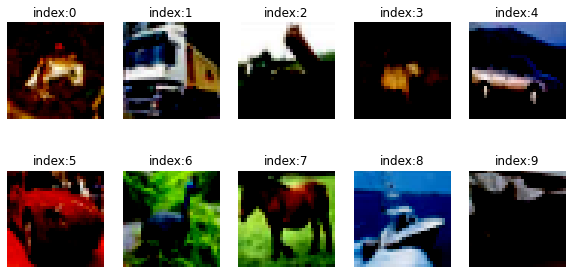

In [12]:
from PIL import Image

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show()

In [19]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

개구리 라벨은 6번입니다. 이상 데이터로 선정된 6번 라벨 데이터를 제외하도록 합시다.

In [30]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:
            #print(old_label)
            new_t_labels.append([0]) # 이상치로 처리
        else:
            new_t_labels.append([1])
    return new_t_labels

In [31]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [36]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []

for data, label in zip(train_data, bol_train_labels):
    if label == [0]:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [37]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [38]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [39]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [40]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


50000건의 데이터를 잘 나눈 것 같습니다. 개구리만 5000장이나 있네요?

In [44]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


데이터셋을 구성하고 label을 검증해봅시다. 

훈련 데이터셋에는 라벨이 1인 데이터만 존재하고 테스트 데이터에는 0과 1이 섞여있어야 합니다.

In [45]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [48]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=int32)


## Step 2. Skip-GANomaly 모델의 구현


### Generator

In [89]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [90]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [79]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel = 3):
        super(Generator, self).__init__()
        
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2,
                                                  padding='same', use_bias=False,
                                                  kernel_initializer=tf.random_normal_initializer(0., 0.02))
        
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator

Discriminator도 Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다.



In [80]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                    use_bias = False, activation='sigmoid')
        
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [91]:
generator = Generator(num_output_channel=3)
discriminator = Discriminator()

### Loss 함수

GAN 모델의 핵심은 Loss 함수의 구성방법에 달려 있다고 해도 과언이 아닙니다. Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.

In [82]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [83]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [84]:
def generator_loss(real_output, fake_output, 
                   input_data, gen_data, 
                   latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
        w_context * context_loss + \
        w_encoder * encoder_loss

    return total_gen_loss

In [85]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## Step 3. 모델 학습과 검증

### Model Train

본격적으로 모델을 학습시켜봅시다!

In [86]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [87]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
    
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
max_epochs = 5
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps : 100, 	 T

Steps : 7500, 	 Total Gen Loss : 20.62744140625, 	 Total Dis Loss : 0.012571100145578384
Steps : 7600, 	 Total Gen Loss : 21.312015533447266, 	 Total Dis Loss : 0.006426719948649406
Steps : 7700, 	 Total Gen Loss : 23.053009033203125, 	 Total Dis Loss : 0.006357967853546143
Steps : 7800, 	 Total Gen Loss : 20.81296730041504, 	 Total Dis Loss : 0.0044759297743439674
Steps : 7900, 	 Total Gen Loss : 21.43758201599121, 	 Total Dis Loss : 0.003276082221418619
Steps : 8000, 	 Total Gen Loss : 21.98386573791504, 	 Total Dis Loss : 0.001989067532122135
Steps : 8100, 	 Total Gen Loss : 20.911640167236328, 	 Total Dis Loss : 0.0013820463791489601
Steps : 8200, 	 Total Gen Loss : 24.292871475219727, 	 Total Dis Loss : 0.004574926104396582
Steps : 8300, 	 Total Gen Loss : 20.010971069335938, 	 Total Dis Loss : 0.10062025487422943
Steps : 8400, 	 Total Gen Loss : 23.793867111206055, 	 Total Dis Loss : 0.0035297181457281113
Steps : 8500, 	 Total Gen Loss : 27.462818145751953, 	 Total Dis Loss : 0.0